# Usando callbacks

### Importando as bibliotecas

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Resetando o gerador de sequências pseudo-aleatórias

In [2]:
seed = 42
np.random.seed(seed)

### Definindo o dataset

Para entender como as *callbacks* funcionam, vamos gerar um conjunto maior de exemplos ruidosos e dividí-los em conjuntos de treinamento e validação.

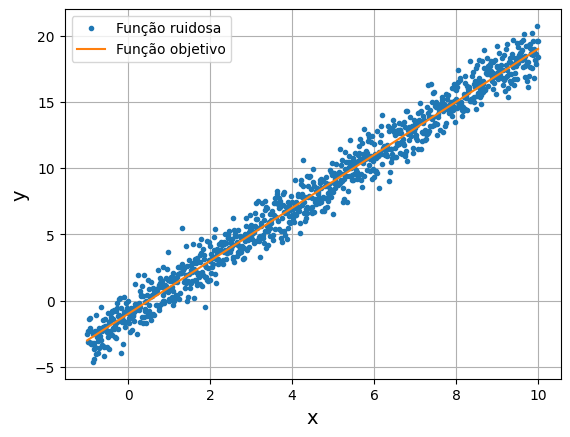

In [3]:
# Número total de amostras.
N = 1000

# Atributo: N valores linearmente espaçados no intervalo de -1 a 10.
x = np.linspace(-1, 10, N)

# Função objetivo.
y = -1 + 2*x

# Ruído.
w = np.random.randn(N,)

# Versão ruidosa da função objetivo.
y_noisy = y + w

# Plotando os dados gerados.
plt.plot(x, y_noisy, '.', label='Função ruidosa')
plt.plot(x, y, label='Função objetivo')
plt.legend()
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.grid()
plt.show()

### Dividindo o conjunto total de amostras

Dividimos o conjunto total de amostras em conjuntos de treinamento e validação.

Para isso, usamos a função `train_test_split()` da biblioteca SciKit-Learn.

O parâmetro `test_size` define a porcentagem do conjunto total que será usada para cirar o conjunto de validação.

O parâmetro `random_state` controla o embaralhamento aplicado aos dados antes de aplicar a divisão.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.3, random_state=seed)

### Definindo a rede neural

O código abaixo uma rede neural densa com um neurônio e entrada com uma dimensão.

Para mais informações sobre as classes e funções do TF, acesse: https://www.tensorflow.org/api_docs

In [14]:
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilando o modelo

Usamos como **otimizador** o gradiente descendente estocástico (SGD) e como **função de erro** o erro quadrático médio.

**OBS**.:

+ O valor do passo de aprendizagem do SGD é o valor padrão da classe, que é igual a $0.01$.

+ Para alterar esse valor, precisamos instanciar um objeto da classe SGD e passar o novo valor para seu construtor através do parâmetro `learning_rate`.

+ Isso é válido para qualquer outro otimizador da biblioteca TensorFlow.

In [15]:
model.compile(optimizer='sgd', loss='mean_squared_error')

### Criando a callback `ModelCheckpoint`

+ A callback `ModelCheckpoint` **salva pontos de verificação do modelo em intervalos regulares** durante o treinamento, por **padrão ao final de cada época**.
  + O parâmetro `save_freq`, pode ser configurado com a string `'epoch'` ou um valor inteiro. Ao usar `'epoch'`, a callback salva o modelo após cada época de treinamento. Ao usar um valor inteiro, a callback salva o modelo ao final do número de mini-batches especificado.
<br/><br/>

+ Se usarmos um **conjunto de validação** durante o treinamento, podemos definir o parâmetro `save_best_only=True` ao criar a callback `ModelCheckpoint`.
  + Nesse caso, a callback só salvará o modelo quando seu desempenho no conjunto de validação for o melhor até o momento.
<br/><br/>

+ Dessa forma, não precisamos nos preocupar em treinar por muito tempo e sobreajustar ao conjunto de treinamento: basta restaurar o último modelo salvo após o treinamento e este será o melhor modelo no conjunto de validação.
  + Precisamos restaurar o modelo manualmente após o treinamento.
<br/><br/>

+ Esta é uma maneira simples de implementar a parada antecipada (i.e., *early-stop*).
  + Entretanto, o treinamento não é encerrado antecipadamente, ele ocorre até a última época definida.

In [16]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./my_regression_model.keras", save_best_only=True)

### Criando a callback `EarlyStopping`

+ A **parada antecipada** propriamente dita é implementada através da callback `EarlyStopping`.
<br/><br/>

+ **Ela interromperá o treinamento** quando não medir nenhum progresso no conjunto de validação por várias épocas (definidas pelo parâmetro `patience`) e, **opcionalmente, carrega o melhor modelo ao final do treinamento**.
   + Por padrão, a métrica avaliada para encerrar o treinamento é o erro no conjunto de validação.
   + Para que o melhor modelo seja carrega ao final do treinamento, o parâmetro `restore_best_weights` deve ser feito igual a `True`.
<br/><br/>

+ Podemos combinar as duas callbacks para salvar os pontos de verificação do modelo com a `ModelCheckpoint` (no caso de seu computador travar) e interromper o treinamento mais cedo quando não houver mais progresso, com a `EarlyStopping` (para evitar desperdício de tempo e recursos).

In [17]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

### Treinando o modelo

+ O número de épocas pode ser definido como um **valor grande** (e.g., 1000), **pois o treinamento será interrompido automaticamente quando não houver mais progresso**.
<br/><br/>

+ Além disso, não há necessidade de restaurar o melhor modelo após o treinamento. A callback `EarlyStopping` armazenará os melhores pesos (que resultaram no menor erro de validação) e os restaurará ao final do treinamento quando `restore_best_weights=True`.
<br/><br/>

+ As *callbacks* são passadas para o método `fit` como uma **lista** através do parâmetro `callbacks`.
<br/><br/>

+ O conjunto de validação é passado para o método `fit` através do parâmetro `validation_data`. O erro no conjunto de validação será avaliado ao final de cada época. Lembrem-se que o modelo não é treinado com esses dados.

In [18]:
# Ajusta o modelo aos dados (também conhecido como treinar o modelo)
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.3739 - val_loss: 1.3487
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3910 - val_loss: 1.3862
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3151 - val_loss: 1.1643
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1771 - val_loss: 1.0989
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1415 - val_loss: 1.0632
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1180 - val_loss: 1.0272
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0337 - val_loss: 1.0143
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9574 - val_loss: 1.0050
Epoch 9/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9306 - val_loss: 0.9884
Epoch 10/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0536 - val_loss: 0.9729
Epoch 11/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9848 - val_loss: 1.0081
Epoch 12/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

**Observações**

+ Percebam que o treinamento é encerrado antes que as 1000 épocas sejam completadas. Isso significa que a *callback* `EarlyStopping` não verificou redução no valor do erro no conjunto de validação por 10 épocas.
<br/><br/>

+ Caso o método `fit` seja executado novamente, o treinamento continua de onde ele parou durante a última chamada do método. Isso significa que o modelo aprende a partir da última atualização dos pesos.

### Plotando o histórico de erros ao longo das épocas de treinamento

O objeto da classe `History` possui um atributo chamado de `history`, que é um **dicionário** com os valores dos erros de treinamento e de validação ao longo das épocas de treinamento.

Esse dicionário pode conter outras medidas feitas longo do treinamento do modelo, para isso, basta especificar a métrica que se quer medir através do parâmetro `metrics` do método `compile()`.

In [19]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


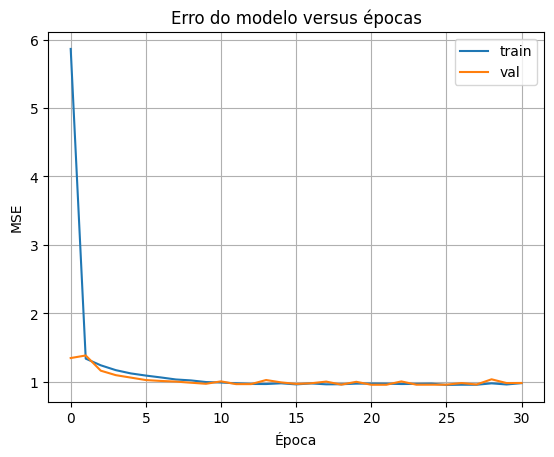

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro do modelo versus épocas')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Comparando os dados originais com a função hipótese

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


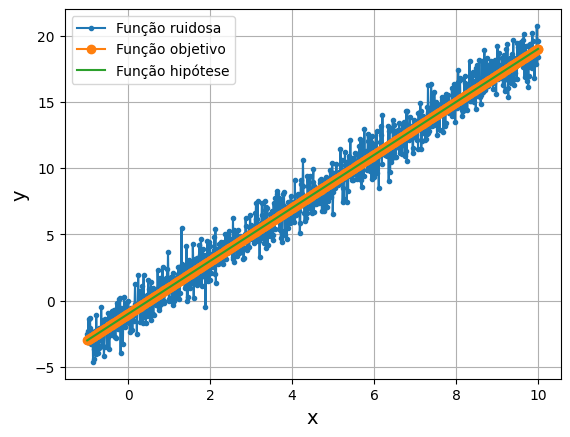

In [12]:
plt.plot(x, y_noisy, marker='.', label='Função ruidosa')
plt.plot(x, y, marker='o', label='Função objetivo')
plt.plot(x, model.predict(x), label='Função hipótese')
plt.grid()
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
plt.show()

### Carregando um modelo salvo

Para carregar um modelo treinando, usamos a função `load_model()`.

In [ ]:
loaded_model = tf.keras.models.load_model('my_regression_model.keras')

### Continuando o treinamento de um modelo salvo de onde ele parou

In [ ]:
loaded_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500)

Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4637e-12 - val_loss: 2.6462e-12
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5704e-12 - val_loss: 2.6462e-12
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6846e-12 - val_loss: 2.6462e-12
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5453e-12 - val_loss: 2.6462e-12
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4760e-12 - val_loss: 2.8537e-12
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8198e-12 - val_loss: 2.8537e-12
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9545e-12 - val_loss: 3.3930e-12
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2342e-12 - val_loss: 3.3930e-12
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2393e-12 - val_loss: 3.1331e-12
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9310e-12 - val_loss: 3.1331e-12
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9404e-